In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # Not entirely sure how to import the raw .mat data
from mne_connectivity import spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout
import autoreject

mat_data = loadmat("Matlab Files/609_Depression_REST.mat")

In [3]:
eeg_signal = mat_data['EEG']['data'][0,0]

sampling_rate =  mat_data['EEG']['srate'][0,0][0,0]

chanlocs = mat_data['EEG']['chanlocs'][0,0]
channel_names = [str(chan[0]) for chan in chanlocs['labels'][0]]

In [4]:
print(len(channel_names))
print(channel_names)

66
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEOG', 'VEOG']


In [5]:
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=['eeg']*59+['misc']+['eeg']*3+['misc']+['eog']*2)

In [6]:
info.set_montage("standard_1020", match_case=False, on_missing='warn')

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG, 2 misc, 2 EOG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>

In [7]:
raw = mne.io.RawArray(eeg_signal, info)

Creating RawArray with float64 data, n_channels=66, n_times=252860
    Range : 0 ... 252859 =      0.000 ...   505.718 secs
Ready.


raw.plot(scalings='auto')

In [9]:
# Let's work with theta data for now

filtered_data = raw.copy().filter(l_freq=1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using EOG channels: HEOG, VEOG
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel HEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 65 significant peaks
Number of EOG events detected: 65
Not setting metadata
65 matching events found
No baseline correction applied
Using data from preloaded Raw for 65 events and 501 original time points ...
0 bad epochs dropped
Applying baseline cor

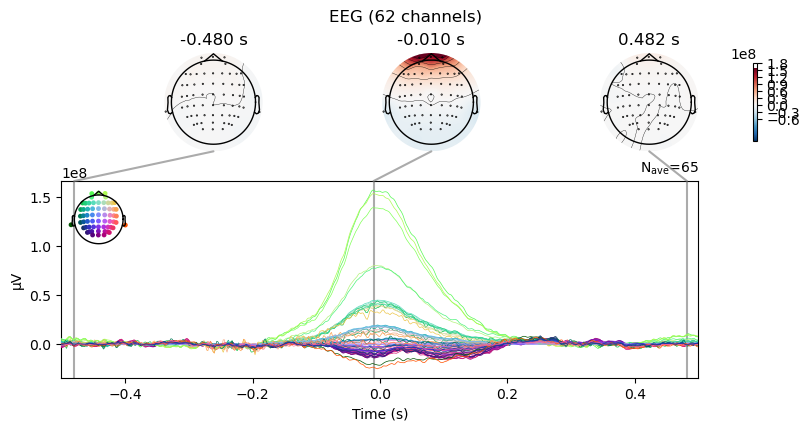

In [10]:
eog_evoked = mne.preprocessing.create_eog_epochs(filtered_data).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint();

In [11]:
ecg_evoked = mne.preprocessing.create_ecg_epochs(filtered_data).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint();

ValueError: Generating an artificial ECG channel can only be done for MEG data

In [37]:
raw.plot(scalings='auto', title='Unprocessed raw')

Using qt as 2D backend.


In [ ]:
epochs = mne.make_fixed_length_epochs(filtered_data, duration = 3, preload = True)
ar = autoreject.AutoReject(random_state=42)
ar.fit(epochs)

Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 1500 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/62 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/62 [00:00<?,       ?it/s]

In [ ]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

In [ ]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

In [ ]:
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T*1e6, 'r', zorder = -1);
epochs_ar.average().plot(axes=plt.gca());

In [ ]:
print(evoked_bad.times.shape)
print(evoked_bad.data.shape)

In [ ]:
epochs[reject_log.bad_epochs].plot(scalings='auto', title='Bad epochs from first autoreject')

In [ ]:
epochs_ar.plot(scalings='auto', title='Cleaned epochs from first autoreject')

In [ ]:
ica=mne.preprocessing.ICA(max_iter='auto', random_state=42)
ica.fit(epochs[~reject_log.bad_epochs])
ica

In [ ]:
print(ica.get_explained_variance_ratio(filtered_data))
ica.plot_sources(filtered_data.copy().pick('eeg'))

In [ ]:
ica.plot_components();

In [ ]:
# blinks + heartbeats
ica.exclude=[]
ica.plot_overlay(raw, picks="eeg");

In [ ]:
ecg_indices, ecg_scores = ica.find_bads_ecg(filtered_data)
print(ecg_indices)
ica.plot_scores(ecg_scores);

In [ ]:
eog_indices, eog_scores = ica.find_bads_eog(filtered_data)
print(eog_indices)
ica.plot_scores(eog_scores);

In [ ]:
ica.exclude = ecg_indices+eog_indices+[25]

In [ ]:
ica.plot_sources(ecg_evoked);

In [ ]:
ica.plot_sources(eog_evoked);

In [ ]:
filtered_data_clean = filtered_data.copy()

ica.apply(filtered_data_clean)

In [ ]:
filtered_data_clean.plot(scalings='auto')

In [ ]:
epochs = mne.make_fixed_length_epochs(filtered_data_clean, duration=2)
eeg_epochs=epochs.load_data().copy().pick('eeg')

In [ ]:
min_freq = 4
max_freq = 7
freqs = np.linspace(min_freq, max_freq, 10)
con_time = spectral_connectivity_time(eeg_epochs, freqs, method='pli', average=True,mode='multitaper', n_cycles=freqs/2, fmin=min_freq, fmax=max_freq)

In [ ]:
con_time_data = con_time.get_data(output='dense')

In [ ]:
con_time_data.shape

In [ ]:
plt.figure(figsize=(8,8))

# if con_time contains 3 data for each freq range of interest: con_plot = plt.imshow(con_time_array[:,:,2], cmap='binary')
con_plot = plt.imshow(np.mean(con_time_data, axis=2), cmap='magma')
plt.title('Spectral connectivity time')
plt.xticks(range(len(channel_names)), channel_names, fontsize=7, rotation=90)
plt.yticks(range(len(channel_names)), channel_names, fontsize=7)

plt.show();

In [54]:
plot_sensors_connectivity(epochs.info, con=np.mean(con_time_data, axis=2), picks='eeg')

Using pyvistaqt 3d backend.


In [55]:
filtered_data_clean=filtered_data_clean.filter(4,7)
mne.set_eeg_reference(filtered_data_clean, ref_channels='average', projection=True)

fsaverage_path = mne.datasets.fetch_fsaverage()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
0 files missing from root.txt in C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice
0 files missing from bem.txt in C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage


In [58]:
src_space = mne.setup_source_space('fsaverage', 'ico3', add_dist='True')

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 3

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\lh.white...
Mapping lh fsaverage -> ico (3) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 642/163842 selected to source space (ico = 3)

Loading C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\rh.white...
Mapping rh fsaverage -> ico (3) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\rh.sphere...
Setting up the triang

Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\outer_skin.surf


C:\Users\fmava\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


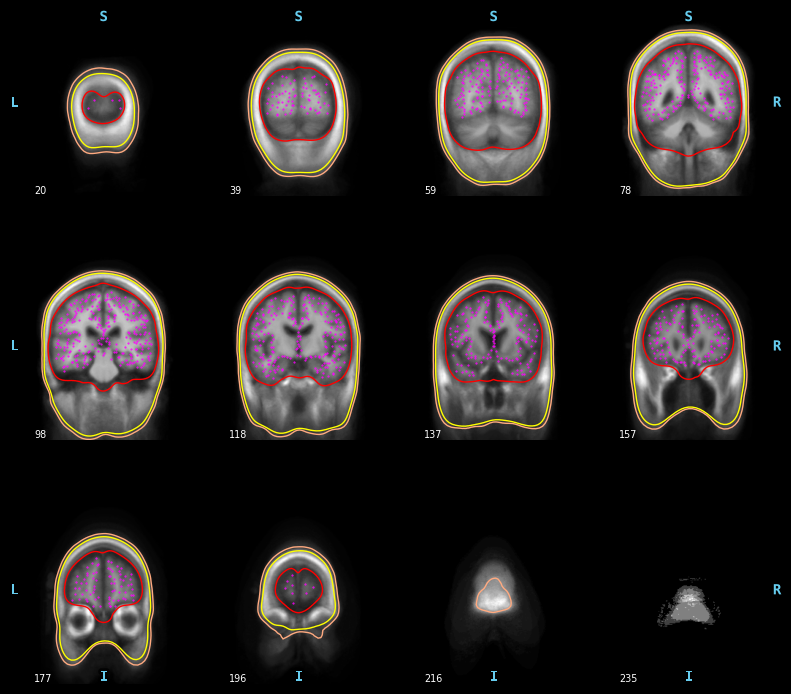

In [59]:
mne.viz.plot_bem('fsaverage', src=src_space);

In [60]:
bem_sol = mne.read_bem_solution('fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif')

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif


In [61]:
fwd_solution = mne.make_forward_solution(filtered_data_clean.info, 'fsaverage', src_space, bem_sol)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=642>, <surface (rh), n_vertices=163842, n_used=642>] MRI (surface RAS) coords, subject 'fsaverage', ~32.7 MB>
MRI -> head transform : C:\Users\fmava\anaconda3\envs\mne\Lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 1284 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  62 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel 

In [62]:
noise_cov=mne.make_ad_hoc_cov(filtered_data_clean.info)

inv_operator = make_inverse_operator(filtered_data_clean.info, fwd_solution, noise_cov=noise_cov, depth=None, loose='auto', verbose=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 62 channels.
    62 out of 62 channels remain after picking
Selected 62 channels
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 5.5e-18 (2.2e-16 eps * 62 dim * 0.0004  max singular value)
    Estimated rank (eeg): 61
    EEG: rank 61 computed from 62 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.87968
    scaling factor to adjust the trace = 4.20586e+20 (nchan = 62 nzero = 1)


In [63]:
snr=1.0
lambda2=1.0/snr**2
mne.set_eeg_reference(eeg_epochs, ref_channels='average', projection=True)
stcs=apply_inverse_epochs(eeg_epochs, inv_operator, lambda2=lambda2)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 61 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 62 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 248
combining the current components...
Processing epoch : 2 / 248
combining the current components...
Processing epoch : 3 / 248
combining the current components...
Processing epoch : 4 / 248
combining the current components...
Processing epoch : 5 / 248
combining the current components...
Processing

In [64]:
labels=mne.read_labels_from_annot('fsaverage')
label_colors=[label.color for label in labels]
label_names=[label.name for label in labels]
lh_labels=[name for name in label_names if name.endswith('lh')]
rh_labels=[name for name in label_names if name.endswith('rh')]

label_ypos=list()
for name in lh_labels:
    idx=label_names.index(name)
    ypos=np.mean(labels[idx].pos[:,1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]
rh_labels = [label for (yp, label) in sorted(zip(label_ypos, rh_labels))]

Reading labels from parcellation...
   read 35 labels from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\label\rh.aparc.annot


In [65]:
print(len(lh_labels), len(rh_labels))

35 34


In [66]:
inv_operator['src']

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=282>, <surface (rh), n_vertices=163842, n_used=282>] head coords, subject 'fsaverage', ~42.1 MB>

In [67]:
# Filter out labels that have no vertices in the source space
valid_labels = []
lh_vertices=inv_operator['src'][0]['vertno']
rh_vertices=inv_operator['src'][1]['vertno']

for label in labels:
    label_vertices=label.vertices
    if any(v in lh_vertices for v in label_vertices) or any(v in rh_vertices for v in label_vertices):
        valid_labels.append(label)

In [68]:
print(len(labels))
print(len(valid_labels))

69
63


In [80]:
# Ok, I'm still getting an error saying 'bankssts-lh', 'inferiortemporal-lh' don't contain vertices, so 
# I don't care anymore, I'm just gonna remove them manually

# Define the labels to remove manually (those causing the error)
labels_to_remove = ['bankssts-lh','inferiortemporal-lh']

# Manually filter out labels that are in the `labels_to_remove` list
valid_labels = [label for label in valid_labels if label.name not in labels_to_remove]

In [82]:
print(len(labels))
print(len(valid_labels))

69
61


In [88]:
label_ts=mne.extract_label_time_course(
    stcs, valid_labels, src=inv_operator['src'], mode="mean_flip", return_generator=True
)

In [90]:
from mne_connectivity import spectral_connectivity_epochs

label_cons = spectral_connectivity_epochs(
    label_ts,
    method='pli',
    mode="multitaper",
    fmin=3,
    fmax=7,
    sfreq=filtered_data_clean.info['sfreq'],
    faverage=True,
    mt_adaptive=True,
)

Connectivity computation...
Extracting time courses for 61 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.998s for estimation (1000 points)
    frequencies: 3.0Hz..7.0Hz (9 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 2
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 3
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 4
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 5
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral densit

In [92]:
label_cons_data = label_cons.get_data(output='dense').mean(axis=2)

In [94]:
print(label_cons_data.shape)
print(len(valid_labels))

(61, 61)
61


In [96]:
valid_label_names = [label.name for label in valid_labels]
lh_labels=[name for name in valid_label_names if name.endswith('lh')]
rh_labels=[name for name in valid_label_names if not (name.endswith('lh'))]

label_ypos=list()
for name in lh_labels:
    idx=label_names.index(name)
    ypos=np.mean(labels[idx].pos[:,1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for label in sorted(lh_labels)]
rh_labels = [label for label in sorted(rh_labels)]

In [98]:
print(len(node_order))
print(len(valid_labels))
print(len(lh_labels), len(rh_labels))
print(len(valid_label_names))
print(len(node_angles))

NameError: name 'node_order' is not defined

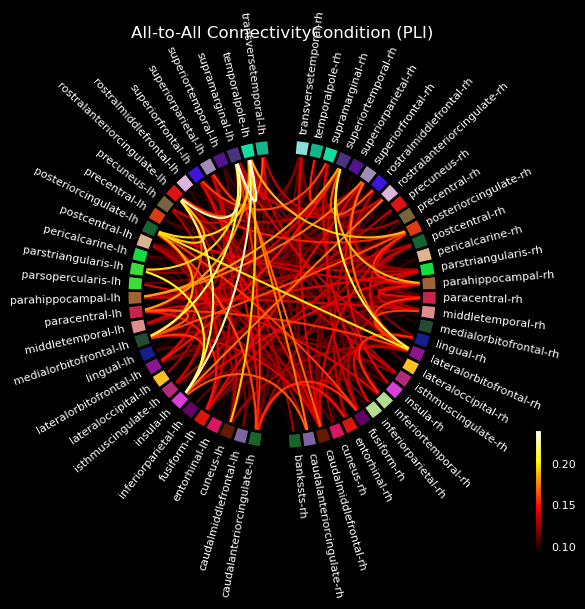

In [100]:
from mne_connectivity.viz import plot_connectivity_circle

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(
    valid_label_names, node_order, start_pos=90, group_boundaries=[0, len(valid_labels) / 2]
)

con_square_matrix=np.mean(con_time_data, axis=2)

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))

plot_connectivity_circle(
    con=label_cons_data,
    node_names=valid_label_names,
    n_lines=300,
    node_angles=node_angles,
    node_colors=label_colors,
    title="All-to-All Connectivity" "Condition (PLI)",
    ax=ax,
)
fig.tight_layout()